In [34]:
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt

sys.path.append(r"..")
sys.path.append(r"../..")
sys.path.append(r"../../..")

from learning.collections_env import CollectionsEnv
from dcc import Parameters, AAV
import utils

In [3]:
p = Parameters()
w0 = 200

col_env = CollectionsEnv(params=p)

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


First lets check whether the process forms a HP

In [4]:
def get_arrivals(env, T, policy=None):
    env.reset(np.array([1.0, 100.]))
    if policy is None:
        a = 0.0
    
    time = 0.0
    while time<T:
        nextst, rew, done, _ = env.step(a)
        time += env.dt
    return env

In [5]:
T = 10000
get_arrivals(col_env, T)

In [6]:
arrivals = col_env.arrivals
reps = col_env.repayments
print(f"Number of arrivals: {len(arrivals)}")

Number of arrivals: 1728


P-value: 0.36110882337357425


0.36110882337357425

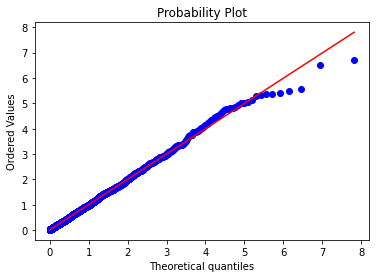

In [7]:
utils.modelcheck(np.array(arrivals), np.array(reps), p, verbose=True)

Lets time the step function

In [8]:
%%timeit
col_env.step(0)

6.77 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%%timeit
col_env.reset(np.array([1.0, 200.]))

4.96 µs ± 36.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is super fast, we probably don't need anything more fancy than that

Value Of an account:

In [388]:
s0 = np.array([0.75, 200.])
aav = AAV(p)
-aav.u(s0[0], s0[1])

[INFO] [2021-02-17 20:40:17,599] [AAV] - Instantiated @ AAV


140.35357428572743

In [389]:
def single_value(env, state, policy=None, n_iter=10000):
    '''
    Run the environment multiple times
    Parameters:
                env: collections_environment instance
                state : np.ndarray
    '''
    reward_history = []
    if policy is None:
        def policy(state, *args, **kwargs):
            return 0.0, None
    df = np.exp(-env.params.rho * env.dt)
    for i in range(n_iter):
        ob = env.reset(state)
        done = False
        reward = 0.
        while not done:
            a, q = policy(ob, epsilon=0.0)
            new_ob, r, done, _ = env.step(a)
            # self.env.render()
            reward += r * np.power(df, env.current_step) 
            ob = new_ob
        reward_history.append(reward)
    return reward_history

In [402]:
vals = single_value(col_env, s0, n_iter=10000)

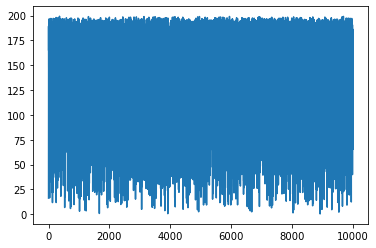

In [403]:
plt.plot(vals)

In [404]:
np.mean(vals)

138.48375487971515

In [405]:
%%timeit
single_value(col_env, s0, n_iter=10000)

58 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [272]:
# %load_ext line_profiler
%prun single_value(col_env, s0, n_iter=1000)

         1620499 function calls in 3.993 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   396700    1.482    0.000    2.812    0.000 collections_env.py:118(step)
        1    1.150    1.150    3.993    3.993 <ipython-input-225-3adbcdb21dff>:1(single_value)
   396700    0.750    0.000    0.750    0.000 collections_env.py:113(intensity_integral)
   390961    0.528    0.000    0.528    0.000 collections_env.py:159(drift)
     5739    0.029    0.000    0.029    0.000 {method 'uniform' of 'numpy.random.mtrand.RandomState' objects}
   396700    0.024    0.000    0.024    0.000 <ipython-input-225-3adbcdb21dff>:10(policy)
     6739    0.018    0.000    0.018    0.000 {method 'exponential' of 'numpy.random.mtrand.RandomState' objects}
     5739    0.004    0.000    0.035    0.000 repayment_distribution.py:23(draw)
     1000    0.002    0.000    0.007    0.000 collections_env.py:81(reset)
     5739    0.002    0.000    0.031    0.0

In [273]:
%lprun -f single_value single_value(col_env, s0, n_iter=1000)

Timer unit: 1e-07 s

Total time: 7.06956 s
File: <ipython-input-225-3adbcdb21dff>
Function: single_value at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def single_value(env, state, policy=None, n_iter=10000):
     2                                               '''
     3                                               Run the environment multiple times
     4                                               Parameters:
     5                                                           env: collections_environment instance
     6                                                           state : np.ndarray
     7                                               '''
     8         1         16.0     16.0      0.0      reward_history = []
     9         1          9.0      9.0      0.0      if policy is None:
    10         1          8.0      8.0      0.0          def policy(state, *args, **kwargs):
    11                 

Let's paralelize this

In [436]:
import joblib
from copy import deepcopy
import dask

# @dask.delayed
def single_val_par(env, policy, state):
    
    env.reset(state)
    df = np.exp(-env.params.rho * env.dt)
    ob = env.current_state
    
    if policy is None:
        def policy(state, *args, **kwargs):
            return 0, 0
        
    done = False
    reward = 0.0
    
    while not done:
        
        a, q = policy(ob, epsilon=0.0)
        new_ob, r, done, _ = env.step(a)
        reward += r * np.power(df, env.current_step) 
        ob = new_ob
        
    return reward

def single_value_parallel(envi, state, policy=None, n_iter=10000):
    '''
    Run the environment multiple times
    Parameters:
                env: collections_environment instance
                state : np.ndarray
    '''
    # reward_history = np.zeros(n_iter, dtype='float32')
    rews = []
    envi.reset(state)
    with joblib.parallel_backend(n_jobs=10, backend='loky'):
        rews = joblib.Parallel()(joblib.delayed(single_val_par)(deepcopy(envi), policy, state) for _ in range(n_iter))
#     for i in range(n_iter):
#         rews.append(single_val_par(deepcopy(envi), policy, state))
#     for i in range(n_iter):
#         envi.reset(state)
#         reward_history[i] = single_val_par(envi, policy)

    return dask.compute(rews)

In [437]:
col_env.reset(np.array([1.0, 100.]))
single_val_par(col_env, None, s0)

193.57304553841894

In [438]:
vals = single_value_parallel(col_env, s0, policy=None, n_iter=10000)

In [439]:
# plt.plot(vals)

In [440]:
np.mean(vals)

138.1113085007177

In [441]:
np.mean(vals)

138.1113085007177

In [442]:
%%timeit
vals = single_value_parallel(col_env, s0, policy=None, n_iter=10000)

12.1 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [443]:
%prun single_value_parallel(col_env, s0, n_iter=1000)

         37380 function calls (33700 primitive calls) in 1.301 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      176    1.177    0.007    1.177    0.007 {method 'acquire' of '_thread.lock' objects}
        1    0.107    0.107    1.285    1.285 parallel.py:925(retrieve)
  2520/20    0.002    0.000    0.006    0.000 copy.py:132(deepcopy)
     1006    0.001    0.000    0.002    0.000 uuid.py:121(__init__)
   1001/1    0.001    0.000    0.007    0.007 base.py:400(_unpack)
      200    0.001    0.000    0.001    0.000 {method '__deepcopy__' of 'numpy.ndarray' objects}
      180    0.001    0.000    1.178    0.007 _base.py:408(result)
     1006    0.001    0.000    0.003    0.000 uuid.py:759(uuid4)
     1001    0.001    0.000    0.001    0.000 base.py:148(is_dask_collection)
   100/20    0.001    0.000    0.006    0.000 copy.py:237(_deepcopy_dict)
     5101    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}


Let's develop a general, but fast pricer - with numba I guess.

In [41]:
import numba

In [45]:
def t_equation(lambda_start, lambda_sustained, params):
    '''
    Equation for duration to reach a holding region
    '''

    try:
        numerator = (lambda_start - params.lambdainf)
        denominator = lambda_sustained - params.lambdainf

        if lambda_start <lambda_sustained:
            raise f'Parameter lambda_start is lower than the lambda_sustained.'
        elif denominator < 0:
            return np.NaN
        else:
            t = 1 / params.kappa * np.log(numerator / denominator)
            return t
    except:
        print('warning')
        print(f'Numerator {(lambda_start - params.lambdainf)}')
        
def next_arrival(lambda_start):
    # generates interarrival times
    flag_finished = False
    s = 0
    t_to_sustain = t_equation(self.intensities_plus[-1], self.balances[-1])
    n = len(self.interarrivals)
    while not flag_finished:
        lstar = self.controlled_intensity(s, n)
        w = -np.log(np.random.rand()) / lstar
        s = s + w
        d = np.random.rand()
        potential_repayment = np.random.uniform(0.1, 1)
        potential_balance = self.balances[-1] * (1 - potential_repayment)
        intensity_at_jump = self.controlled_intensity(s, n)
        if d * lstar <= intensity_at_jump:
            sustain_drift_time = s - t_to_sustain
            if sustain_drift_time > 0:
                self.continuous_effort_duration = np.append(self.continuous_effort_duration, sustain_drift_time)
                self.continuous_effort_intensity = np.append(self.continuous_effort_intensity, intensity_at_jump)
                self.continuous_effort_start_sustain = np.append(self.continuous_effort_start_sustain,
                                                                 t_to_sustain + sum(self.interarrivals))

            self.control_levels = np.append(self.control_levels, self.control_function(potential_balance))
            self.intensities_minus = np.append(self.intensities_minus, intensity_at_jump)
            self.intensities_plus = np.append(self.intensities_plus, intensity_at_jump + self.delta10 +
                                              self.delta11 * potential_repayment)
            self.interarrivals = np.append(self.interarrivals, s)
            self.relativerepayments = np.append(self.relativerepayments, potential_repayment)
            self.balances = np.append(self.balances, potential_balance)
            flag_finished = True

In [46]:
t_equation(2.0, 1.0, p)

1.0674491454717445

In [44]:
p.lambdainf